<a href="https://colab.research.google.com/github/sommoMicc/DeepLearning-Homeworks/blob/master/HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#HW6: Variational Autoencoder
In this homework, we will explore how to develop a Variational Autoencoder (VAE). As a dataset, we will use the MNIST dataset.
In developing the VAE, we also explore how to develop an ad-hoc layer and a nonstandard training step.


##Load data
We load the MNIST dataset, using tf.keras.datasets. We will use the same code used in HW5

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000], y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

##Exercise 6.1: Variational Autoencoder and the reparameterization trick
The reparameterization trick is an important component of VAE. It allows to implement the sampling phase, while keeping the network trainable via gradient ascent/descent.
Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define the sample layer as a new layer.

To do this we define a new class that inherits from the layer base class tf.keras.layers that is used as base class for all the layers defined in Keras. In particular, from this class we are interested in overriding the call method, that is the one that is called when a layer is exploited by the model, and where the operations executed by the layer are defined.

In our case, the new Sampling layer has in input a mean vector $z_{\mu}$ and a ``variance'' vector $z_{\sigma}$, and it has to compute a sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{\mu} + exp(z_{\sigma}) \odot \epsilon,
$$
where $\epsilon$ is sampled by a normal distribution with zero mean and identity covariance matrix. 

**To complete: complete the code defining the Sampling layer that implements the reparameterization trick**

**Hint: to generate a random value from a normal distribution keras provides the [tf.keras.backend.random_normal](https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_normal) method.**

**In addition to that, explain why in the reparameterization formula it makes sense to use $exp(z_{\sigma})$ instead of directly using $z_{\sigma}$.**


In the reparametrization trick we use $e^{z_{\sigma}}$ instead of $z_{\sigma}$ because in our case $z_{\sigma}$ is the logarithm of the variance. 
The benefits of this choice are that, since variance is usually a very small number $0<\sigma << 1$,computations involving that variable can be numerically unstable (due to the approximations made by the computer). Using the logarithm of the variance, we can work in a much wider interval $(-\infty, log(1))$, so we can avoid huge floating point errors.

Also, note that the exponent of the exponential function is multiplied by 0.5: this is because $z_{\sigma}$ is related to variance, while here we need standard deviation.

Moreover in KL-divergence we need to compute $log(\sigma^2)$ (the logarithm of the variance) anyway.

In [0]:
class Sampling(tf.keras.layers.Layer):
   
    def call(self, inputs):
        z_mean = inputs[0]
        z_variance = inputs[1]
        return tf.add(z_mean, tf.multiply(tf.exp(0.5 * z_variance),tf.keras.backend.random_normal(tf.shape(z_variance)))) 

##Exercise 6.2: Encoder
Now we can define the encoder. Let's use 3 dense layers (similarly to what we did in HW4), and then use the obtained encoding to compute $z_{\mu}$ and $z_\sigma$, by using two different dense layers. Finally, we use the Sampling layer to compute the sample $z$. 

In order to allow the exploration of the latent space, we will stick on a latent space of size $2$ (that is, the dimension of $z$ should be $2$).

**To complete: complete the code defining a deep encoder and the Dense layers that model $z_{\mu}$ and $z_\sigma$. Justify in this cell your choice for what concerns the layers sizes and the activation functions** 

For the encoder I choose three Dense layers, each one with ReLu activation functions. I saw that putting here a sigmoid or tanh implied a sort of stall in gradient descend, with lots of iterations without loss improvement. I think that this is because sigmoid and tanh are more sensible to the gradient vanishing issue.

Once I fixed the activation functions, I have conducted some experiments about layer sizes and number of layers. I obtained the following results (note that the reported number is the total_loss): 

* 256 -> 64 [relu,relu] -> [relu, relu, sigmoid] = 135.3360
* 512 -> 128 [relu, relu] -> [relu, relu, sigmoid] = 132.7069
* 512 -> 256 [relu, relu] -> [relu, relu, sigmoid] = 132.7483
* 512 -> 256 -> 128 [relu, relu, relu] -> [relu, relu, relu, sigmoid] = 130.2916

Considering those results (and the ones explained in section 6.5) I decided to keep the last model



In [0]:
latent_dim = 2

encoder_inputs = tf.keras.layers.Input(shape=(784,))

encoders = []
# steps = [784,368,216,64]
steps = [784,512,256,128]
prev_layer = encoder_inputs

encoder_activations = ['relu','relu','relu']
decoder_activations = ['relu','relu','relu','sigmoid']

for i in range(1,len(steps)):
  step = steps[i]
  act = encoder_activations[(i-1) % len(encoder_activations)]
  print("Encoder #%d: (%d, act: %s)" % (i, step, act))
  encoders.append(tf.keras.layers.Dense(step, activation=act, name="encoder_%d_%d" % (i,step))(prev_layer))
  prev_layer = encoders[-1]

x = encoders[-1]

#...To complete...
z_mean =  tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
z_var =  tf.keras.layers.Dense(latent_dim, name="z_var")(x)

z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

Encoder #1: (512, act: relu)
Encoder #2: (256, act: relu)
Encoder #3: (128, act: relu)
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_74 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder_1_512 (Dense)           (None, 512)          401920      input_74[0][0]                   
__________________________________________________________________________________________________
encoder_2_256 (Dense)           (None, 256)          131328      encoder_1_512[0][0]              
__________________________________________________________________________________________________
encoder_3_128 (Dense)           (None, 128)          32896       encoder_2_256[0][0]              
_____

##Exercise 6.3: Decoder
Then we have to define the decoder part. It has in input $z$ and returns its "decoding". Its topology will have a ``mirror'' shape w.r.t. the encoder. 

**To complete: define the decoder. Explain in this cell your choice for what concerns the number of layers, the layers sizes and the activation functions (in particular for what concerns the last layer)**

Number of layers and sizes of the decoder has already been discussed in previous section. Regarding the activation functions, the deeper layers uses again ReLu, while the last layer a Sigmoid, which allows to obtain outputs in the (0,1) interval, since in the input images pixels are described with a numerical value in the (0,1) range (because we divide the value of each pixel by 255).

In [0]:
latent_inputs = keras.Input(shape=(latent_dim,))

prev_layer = latent_inputs
decoders = []

steps.reverse()

print("---")
for i in range(len(steps)):
  step = steps[i]
  act = decoder_activations[i % len(decoder_activations)]

  print("Decoder #%d: (%d, act: %s)" % (i, step, act))

  decoders.append(tf.keras.layers.Dense(step, activation=act, name="decoder_%d_%d" % (i,step))(prev_layer))
  prev_layer = decoders[-1]

decoder_outputs = decoders[-1]

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

---
Decoder #0: (128, act: relu)
Decoder #1: (256, act: relu)
Decoder #2: (512, act: relu)
Decoder #3: (784, act: sigmoid)
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_75 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
decoder_0_128 (Dense)        (None, 128)               384       
_________________________________________________________________
decoder_1_256 (Dense)        (None, 256)               33024     
_________________________________________________________________
decoder_2_512 (Dense)        (None, 512)               131584    
_________________________________________________________________
decoder_3_784 (Dense)        (None, 784)               402192    
Total params: 567,184
Trainable params: 567,184
Non-trainable params: 0
______________________________________________________________

##Exercise 6.4: Training
Now we can define the VAE, but since it is a generative model, we have to define an ad hoc training phase. In particular, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss that forces the decoded samples to match the original inputs, and a regularization loss that helps to learn well-formed latent spaces (Gaussian prior) and reduces overfitting to the training data. The regularization loss involves the Kullback-Liebler Divergence. While for the reconstruction loss we are supposed to use the negative log-likelihood. Keras, however, does not support it natively, so to make the exercise simple, we will use as a proxy the binary cross-entropy to compare each feature of a data point to the value in the reconstructed output.

Therefore, we have to define a class that inherits from [keras.model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), and overrides the [training_step method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_step), that allows to define a custom training logic.

**To complete: implement the reconstruction loss and KL-loss (look at the VAE paper in Moodle)**

In [0]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_var, z = encoder(data)
            reconstruction = decoder(z)


            reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(data,reconstruction)) * 784
            kl_loss = -0.5 * tf.reduce_mean(1+ z_var - tf.keras.backend.square(z_mean) - tf.exp(z_var))
            
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Let's now train the VAE model using Adam as optimizer

In [0]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30*2, batch_size=128)

Epoch 1/60
391/391 [==============================] - 1s 3ms/step - loss: 187.5242 - reconstruction_loss: 184.5161 - kl_loss: 3.0081
Epoch 2/60
391/391 [==============================] - 1s 3ms/step - loss: 159.4203 - reconstruction_loss: 156.3658 - kl_loss: 3.0545
Epoch 3/60
391/391 [==============================] - 1s 3ms/step - loss: 152.2374 - reconstruction_loss: 148.9497 - kl_loss: 3.2877
Epoch 4/60
391/391 [==============================] - 2s 4ms/step - loss: 148.4261 - reconstruction_loss: 145.0274 - kl_loss: 3.3986
Epoch 5/60
391/391 [==============================] - 2s 4ms/step - loss: 145.4664 - reconstruction_loss: 141.9754 - kl_loss: 3.4910
Epoch 6/60
391/391 [==============================] - 2s 4ms/step - loss: 143.6148 - reconstruction_loss: 140.0609 - kl_loss: 3.5540
Epoch 7/60
391/391 [==============================] - 2s 4ms/step - loss: 142.0335 - reconstruction_loss: 138.4485 - kl_loss: 3.5850
Epoch 8/60
391/391 [==============================] - 2s 4ms/step - l

##Exercise 6.5: Model Analysis
We can now plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate several  2D $\hat{z}$ samples and pass them to our decoder. The interval where to sample  $\hat{z}$ can be controlled by the $scale$ parameter, while the number of generated samples is controlled by the $n$ parameter.


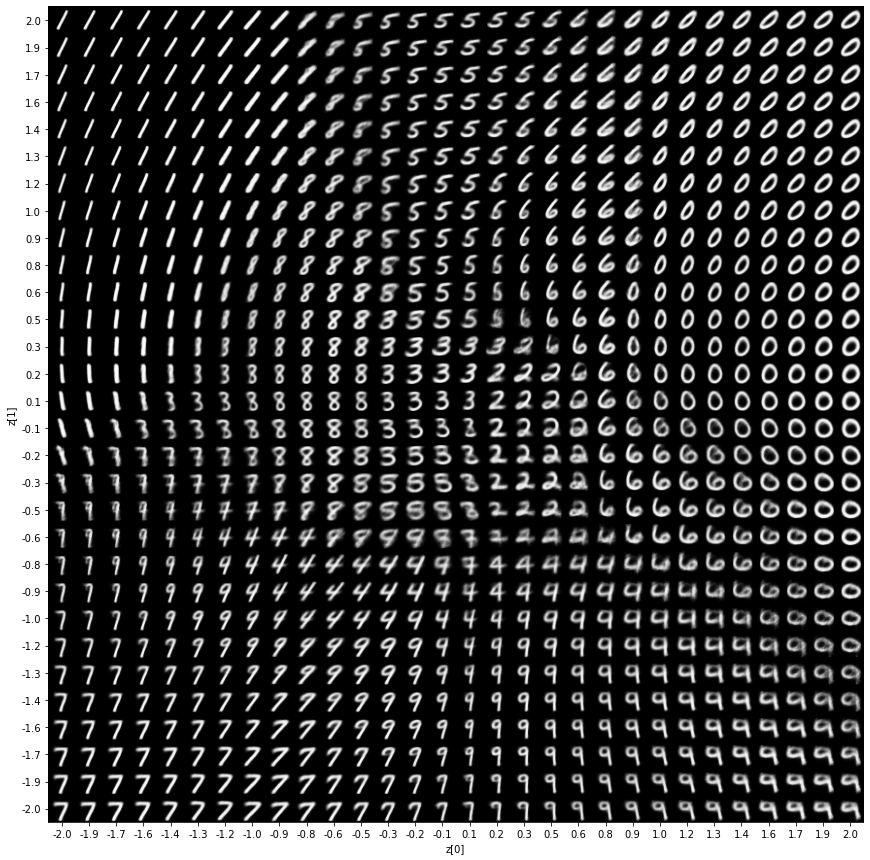

In [0]:
def plot_latent(encoder, decoder, scale=2.0, n = 30):
     
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder, 2, 30) 

#To complete: explore with different "scale"

**Comment**
Varying the scale parameters allows to sample points closer or farther from each other. So, digits will be more similar in case of a smaller _scale_, or more different, in case of a larger scale.
 
 

Let's finaly check how the different digits have been rapresented in the latent space by the VAE.

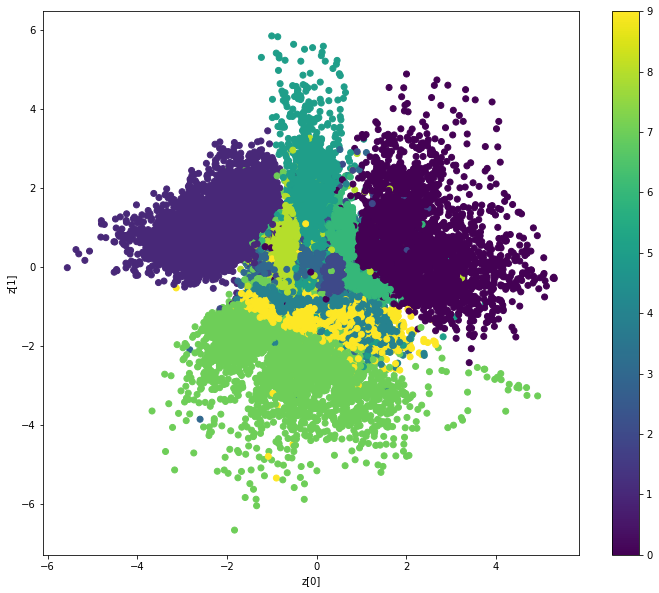

In [0]:
def plot_label_clusters(encoder, decoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, decoder, x_train, y_train)

**To complete: Discuss the obtained plots, and  explore how the hyper-parameters of the VAE (number of layers, layer sizes, etc.) influence the final result.**

The first plot (_lantent plot_) shows how the generated values are distributed among the latent space. As we can see pretty much all depicted images are "meaningful" (in the sense that they represents a "real" number). The only region where images are very blurred and "confused" is near $(z_0 = 0, z_1 = -0.5)$. This is reflected in the second plot (_label cluster plot_), which shows the distributions of the labels in the latent space. In other words, it represents how the two parameters of the latent space contributes in the definition of a digit. 
For example (and consistently with what previously stated) we can see that in the same region  $(z_0 = 0, z_1 = -0.5)$ lots of different labels (colors) intersect, so the generated digits could be a bit cahotic (corrupted/meaningless).
However, overall labels are quite well clustered with very few outliers, so I can say that the quality of the obtained representation is quite good.

Changing the hyperparameters of the network (specifically the number of layers and the layer sizes), I obtain different results, as I'm going to discuss now.

For example, with the previously mentioned 512 -> 256 encoder, I obtain the following representation:
![Cluster 512->256](https://drive.google.com/uc?id=1EYWM7TCAoRnfhTqxL4YPPUDA6KggOv5X)

As we can see, although the loss of the network is 132.7483 (so only two point worse than the reference model), the quality of the representation changes a lot: labels are not well clustered (we can see yellow pretty much everywhere) and there's a lot of overlapping (for example around $(z_0 = 2.5, z_1 = -2)$. 
This fact is reflected alos in the following _latent plot_:
![Latent 512->256](https://drive.google.com/uc?id=13V2ZesI9ecejdXd5siWZIe9FNReHe5el)

Here it's evident how digits generally more confused. 

With an even smaller (and worse) network, like the 256->64 model described before, I obtain the following results:

![Cluster 256->64](https://drive.google.com/uc?id=1OQp6cCLxb-ysJt9iDo_KtVJHqM7pNIaX)

![Latent 256->64](https://drive.google.com/uc?id=1iTcw2hlnJJTzolQbwYQZd9_Qm4LCQDeH)

We can see that labels are more overlapped and digits sampled from the latent space are generally malformed: some of them are just blurred, others are confused and there are also "tilted" ones. In general, the quality of the representation is quite bad, expecially if compared to the reference model.

